# State Estimation

In [1]:
import numpy as np

from sox.estimator.soc_ekf import SOCWithEKF
from sox.battery.ecm.model import Thevenin
from sox.battery.ecm.default.inputs import default_inputs
import sox.battery.protocol as protocol
from sox.sensor.sensor import Sensor
from sox.sensor.noise import Normal
from sox.sensor.fault import Drift, StuckAt
from sox.filter.coulomb_count import CoulombCount
from sox.filter.extended_kalman_filter import ExtendedKalmanFilter


# Synthetic Ground-truth Data

In [2]:
ecm = Thevenin(default_inputs)

dt = 1.0
solution = ecm.solve(protocol.charge_discharge_cycling(number_of_cycles=2, sampling_time_s=dt))

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc
cell_temperature = solution.cell_temperature

# State Estimators

In [33]:
# sets up the coulomb counter

soc_with_coulomb_count = CoulombCount(
    initial_soc=0.75, capacity=default_inputs.capacity, sampling_time=1.0
)


# sets up the extended kalman filter

rc_pairs = 1  # real value: 1
capacity = 10  # real value: 10
initial_soc = 0.75  # real value: 0.8
ocv_func = default_inputs.open_circuit_voltage  
r0 = 4.5e-4  # real value: variable
r1 = 6e-4  # real value: variable
c1 = 5e4  # real value: variable
a1 = np.exp(-dt / (r1 * c1))

F = np.diag([1.0, a1])  # state transition matrix
B = np.array([-dt / capacity / 3600, r1 * (1 - a1)])[:, np.newaxis]  # input matrix
x0 = np.array([initial_soc, 0.0])[:, np.newaxis]  # initial states [soc, v_rc1]
P0 = np.diag([0.005, 0.02])  # initial covariance of states
Q = np.diag([1e-5, 1e-5])  # process noise
R = np.array([[1e-5]])  # measurement noise

ekf = ExtendedKalmanFilter(F, B, Q, R, x0, P0)  # x_bar=Fx+Bu, z=Hx
soc_with_ekf = SOCWithEKF(ocv_func, rc_pairs)


# Sensors

In [34]:
# sets up the sensors

voltage_sensor = Sensor(
    name="voltage sensor",
    time=time,
    data=voltage,
    noise=Normal(0, 0.002),
    faults=[
        StuckAt(start_time=2000, stop_time=2500, value=3.0),
        Drift(start_time=0, stop_time=12000, rate=-0.02 / 3600),
    ],
)
current_sensor = Sensor(
    name="current sensor",
    time=time,
    data=current,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=500, stop_time=1000, value=0.0),
        Drift(start_time=0, stop_time=12000, rate=-0.2 / 3600),
    ],
)
temperature_sensor = Sensor(
    name="temperature sensor",
    time=time,
    data=cell_temperature,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=7000, stop_time=7500, value=30),
        Drift(start_time=0, stop_time=12000, rate=0.1 / 3600),
    ],
)

sensors = [voltage_sensor, current_sensor, temperature_sensor]


# Run Estimation

In [35]:
# runs the state estimation

v_sense = []
curr_sense = []
temp_sense = []
soc_cc = []
soc_ekf = []

try:
    for s in sensors:
        s.reset()
    while True:
        # sensor readings
        voltage_reading, current_reading, temperature_reading = [s.read() for s in sensors]

        # coulomb counting
        soc_with_coulomb_count.update(current_reading)

        # extended kalman filter
        ekf.predict(u=np.array([[current_reading]]))
        ekf.update(
            z=voltage_reading,
            HJacobian=soc_with_ekf.measurement_jacobian,
            Hx=soc_with_ekf.measurement,
            hj_args=(),
            hx_args=(r0, current_reading),
        )

        # store states and sensor readings
        soc_cc.append(soc_with_coulomb_count.soc)
        soc_ekf.append(ekf.x[0, 0])
        v_sense.append(voltage_reading)
        curr_sense.append(current_reading)
        temp_sense.append(temperature_reading)
        
except IndexError as e:
    print(e)

Data streaming finished. No more data available from the sensor


# Plot Results

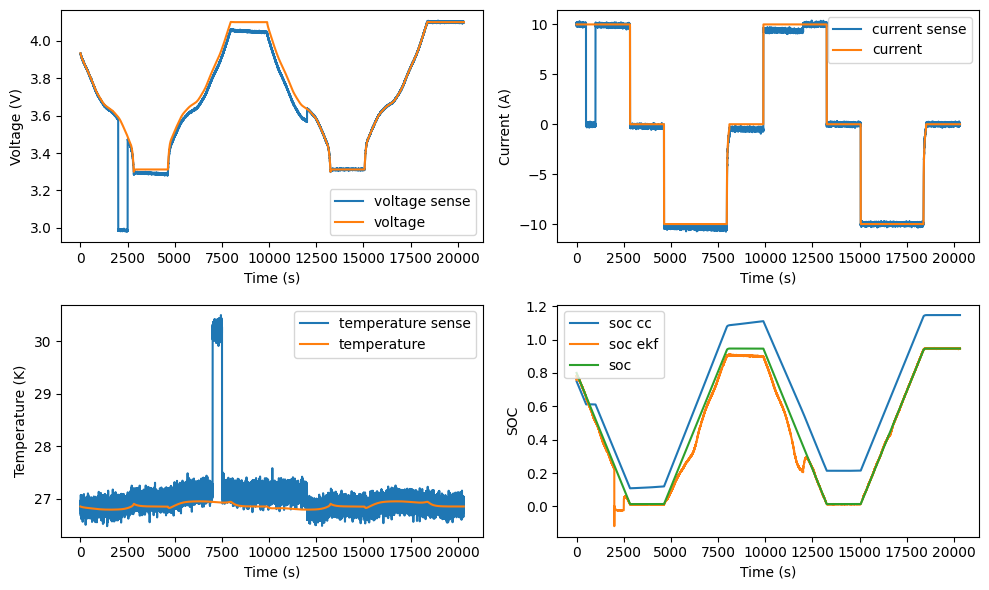

(<Figure size 1000x600 with 4 Axes>,
 array([[<Axes: xlabel='Time (s)', ylabel='Voltage (V)'>,
         <Axes: xlabel='Time (s)', ylabel='Current (A)'>],
        [<Axes: xlabel='Time (s)', ylabel='Temperature (K)'>,
         <Axes: xlabel='Time (s)', ylabel='SOC'>]], dtype=object))

In [36]:
from sox.utils import quick_plot

quick_plot(
    sampling_time = dt,
    data=[
        [v_sense, voltage],
        [curr_sense, current],
        [temp_sense, cell_temperature],
        [soc_cc, soc_ekf, soc]
    ],
    legend = [
        ["voltage sense", "voltage"],
        ["current sense", "current"],
        ["temperature sense", "temperature"],
        ["soc cc", "soc ekf", "soc"]
    ],
    x_label="Time (s)",
    y_label=["Voltage (V)", "Current (A)", "Temperature (K)", "SOC"]
)